# Experiments with the diversity condition violated

In this notebook I will perform the SimCLR experiments where the diversity condition was violated. Mathematically it essentially means that we will use the following distributions for sampling:

- $p(z) = \frac{1}{|\mathcal{Z}|}$ - Marginal distribution is simply a uniform distribution on a sphere
- $p(\tilde{z}|z) = \delta(u-u') \frac{e^{\kappa \tilde{z}^{T}z}}{\int_{W}e^{\kappa v^{T}v' dv}}$

Where the latent space can be decomposed into 2 components $z = (u,v)^{T}$ where $u \in R^{n}$, $v \in R^{m}$, and $m + n = d$ - the dimension of the latent space.

I will primarily work with hyper-spheres as my latent space, hence the condition $z^{2} = u^{2} + v^{2} = 1$ will be enforced.

Experiment with these data-generating processes:

- Identity ✅
- Linear Mapping (to 4D, 5D, 6D, 7D) ✅
- Spirals ✅
- Patches ✅
- Injective Neural Network as a data generating process ✅

For now fix one dimension (the first one):

Consider later:

- Fix multiple dimensions
- Fix dimensions randomly

In [1]:
%load_ext autoreload
%autoreload 2
    
import torch
from torch import nn
from torch import functional
from simclr.simclr import SimCLR
from encoders import get_mlp
import matplotlib.pyplot as plt
from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side

from encoders import get_mlp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 5096
kappa = tau = 8
iterations = 3000
latent_dim = 3

fixed_dims_on_sample = 1

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:,:u_dim]
    v = z[:,u_dim:]

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch) * torch.norm(v, p=2, dim=-1, keepdim=True)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch) # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)
    
sample_uniform_fixed = lambda batch: full_sphere.uniform(batch)
sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, fixed_dims_on_sample)

## Visualizing the constrained sampling procedure

Below you can see how samples from the constrained sampling distribution look like

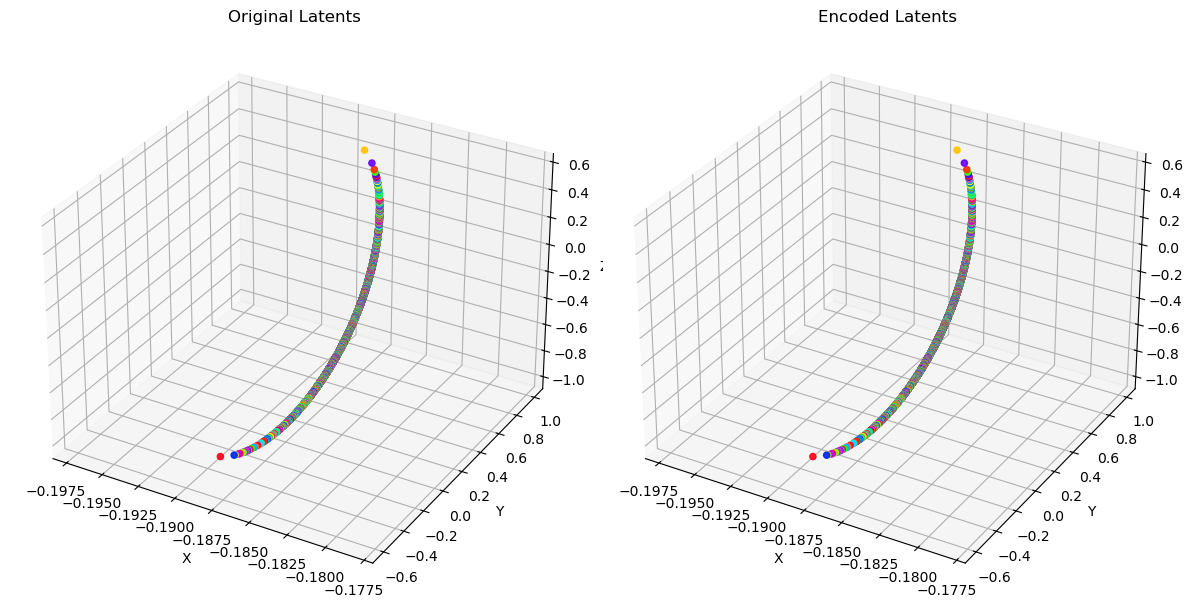

In [2]:
z = sample_uniform_fixed(1).squeeze(0)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch_size) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(batch_size, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

## Training the identity generating process

$g(z) = z$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.536385536193848 Samples processed: 1 linear disentanglement: 0.509942352771759 permutation disentanglement: 0.00020043055701535195
Loss: 8.416250228881836 Samples processed: 251 linear disentanglement: 0.4375217854976654 permutation disentanglement: 0.2709076702594757
Loss: 8.415390014648438 Samples processed: 501 linear disentanglement: 0.4689054489135742 permutation disentanglement: 0.25600528717041016
Loss: 8.415348052978516 Samples processed: 751 linear disentanglement: 0.4234501123428345 permutation disentanglement: 0.2553177773952484
Loss: 8.414593696594238 Samples processed: 1001 linear disentanglement: 0.318184494972229 permutation disentanglement: 0.2607646584510803
Loss: 8.41415023803711 Samples processed: 1251 linear disentanglement: 0.2965237498283386 permutation disentanglement: 0.24604053795337677
Loss: 8.414101600646973 Samples processed: 1501 linear disentanglement: 0.29589030146598816 permutation disentan

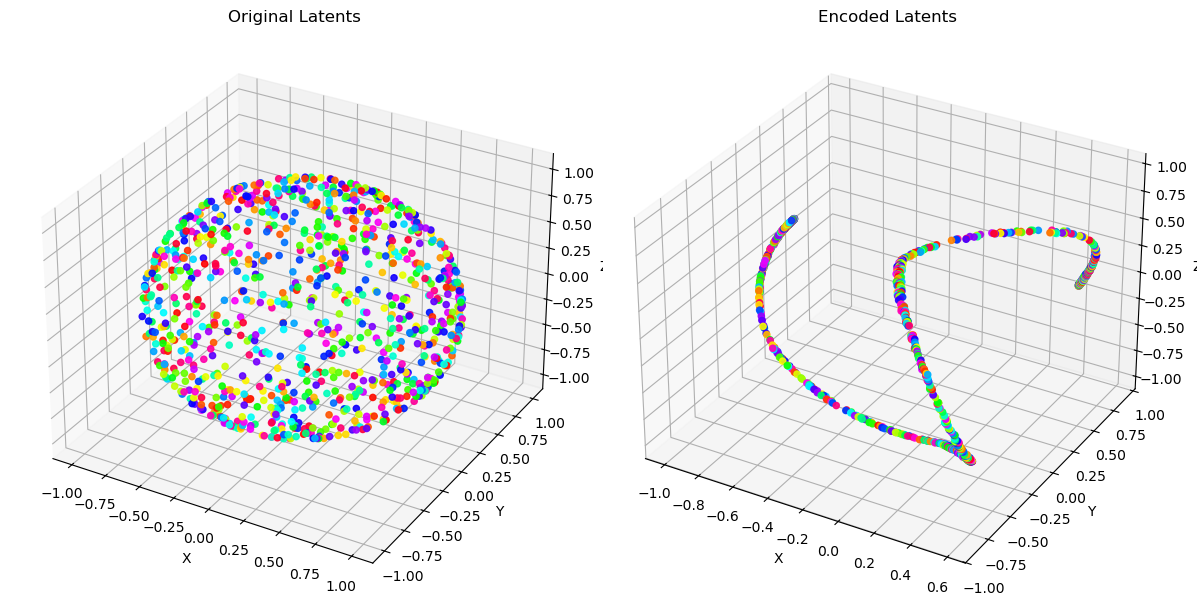

In [24]:
# Initialize the multi-layer perceptron used for encoding
f_constrained = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

g_id = nn.Identity()

simclr_id = SimCLR(
    f_constrained, g_id, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_constrained = simclr_id.train(batch_size, iterations)
h_constrained = lambda z: f_constrained(g_id(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_constrained(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Linear map generating process

$g(z) = Az$, where $A \in \mathbb{R}^{k \times 3}$ and $k \in \{4,5,6,7\}$ and $rank(A) = 3$

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.53639030456543 Samples processed: 1 linear disentanglement: 0.4248316287994385 permutation disentanglement: 0.007140457630157471
Loss: 8.4332857131958 Samples processed: 251 linear disentanglement: 0.40464532375335693 permutation disentanglement: 0.20287460088729858
Loss: 8.415534973144531 Samples processed: 501 linear disentanglement: 0.5374079346656799 permutation disentanglement: 0.011032621376216412
Loss: 8.415255546569824 Samples processed: 751 linear disentanglement: 0.3128521144390106 permutation disentanglement: 0.03205176070332527
Loss: 8.415146827697754 Samples processed: 1001 linear disentanglement: 0.311102032661438 permutation disentanglement: 0.039556264877319336
Loss: 8.414250373840332 Samples processed: 1251 linear disentanglement: 0.2949621379375458 permutation disentanglement: 0.07103387266397476
Loss: 8.41419792175293 Samples processed: 1501 linear disentanglement: 0.29225459694862366 permutation disent

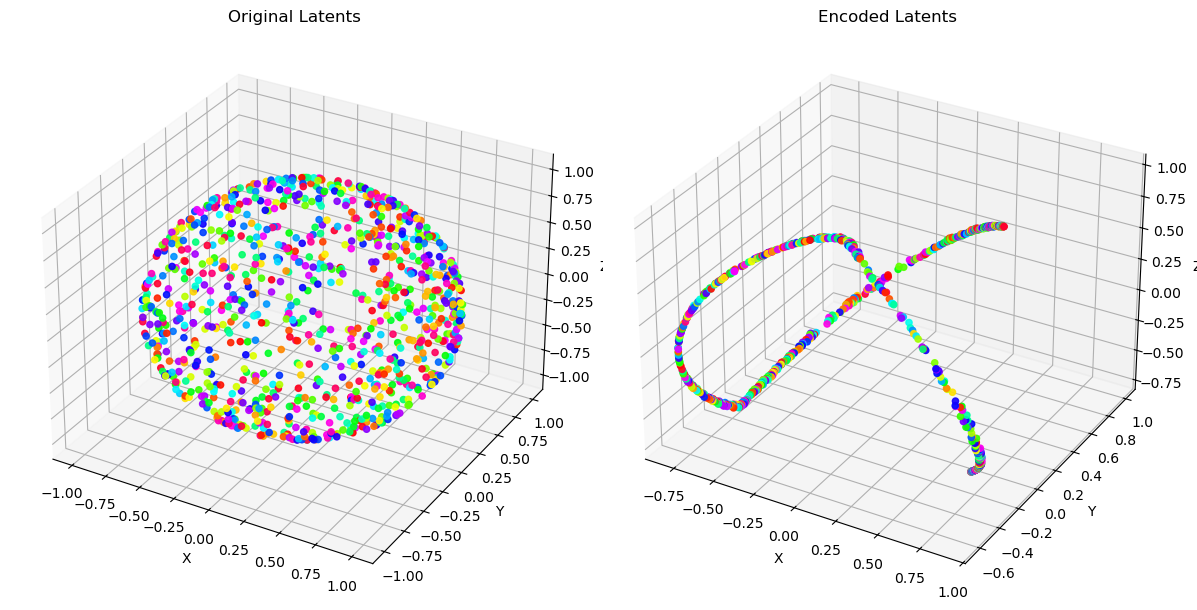

In [3]:
from experiment_utils.linear import perform_linear_experiment

h = perform_linear_experiment(
    4, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.536377906799316 Samples processed: 1 linear disentanglement: 0.6072105169296265 permutation disentanglement: -6.198883056640625e-05
Loss: 8.41539192199707 Samples processed: 251 linear disentanglement: 0.5597296357154846 permutation disentanglement: 0.008406619541347027
Loss: 8.415199279785156 Samples processed: 501 linear disentanglement: 0.3714272975921631 permutation disentanglement: 0.003227929351851344
Loss: 8.414119720458984 Samples processed: 751 linear disentanglement: 0.30157801508903503 permutation disentanglement: 0.027938345447182655
Loss: 8.414151191711426 Samples processed: 1001 linear disentanglement: 0.2995994985103607 permutation disentanglement: 0.025651076808571815
Loss: 8.414170265197754 Samples processed: 1251 linear disentanglement: 0.3023449182510376 permutation disentanglement: 0.025912344455718994
Loss: 8.414085388183594 Samples processed: 1501 linear disentanglement: 0.30069077014923096 permutati

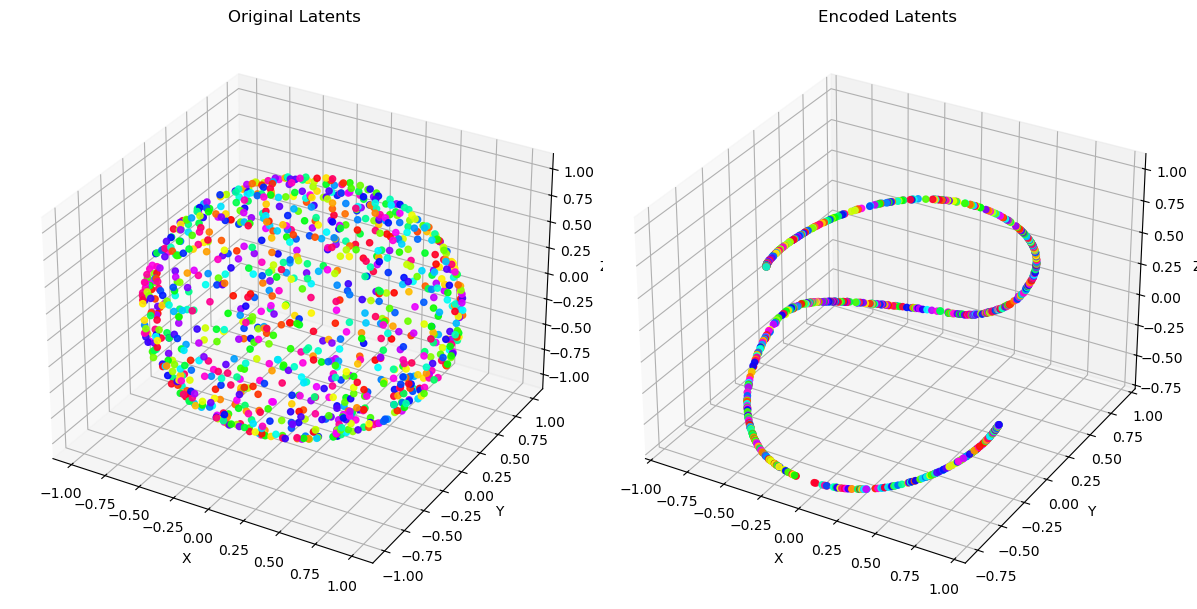

In [34]:
from experiment_utils.linear import perform_linear_experiment

h = perform_linear_experiment(
    5, iterations * 3, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.536312103271484 Samples processed: 1 linear disentanglement: 0.33544817566871643 permutation disentanglement: 0.0008705258369445801
Loss: 8.415616989135742 Samples processed: 251 linear disentanglement: 0.4837270677089691 permutation disentanglement: 0.268974632024765
Loss: 8.415386199951172 Samples processed: 501 linear disentanglement: 0.3355962336063385 permutation disentanglement: 0.25040826201438904
Loss: 8.414518356323242 Samples processed: 751 linear disentanglement: 0.30810773372650146 permutation disentanglement: 0.24730215966701508
Loss: 8.41429615020752 Samples processed: 1001 linear disentanglement: 0.29796749353408813 permutation disentanglement: 0.2341470718383789
Loss: 8.414107322692871 Samples processed: 1251 linear disentanglement: 0.29650911688804626 permutation disentanglement: 0.2391393780708313
Loss: 8.414079666137695 Samples processed: 1501 linear disentanglement: 0.29576611518859863 permutation dise

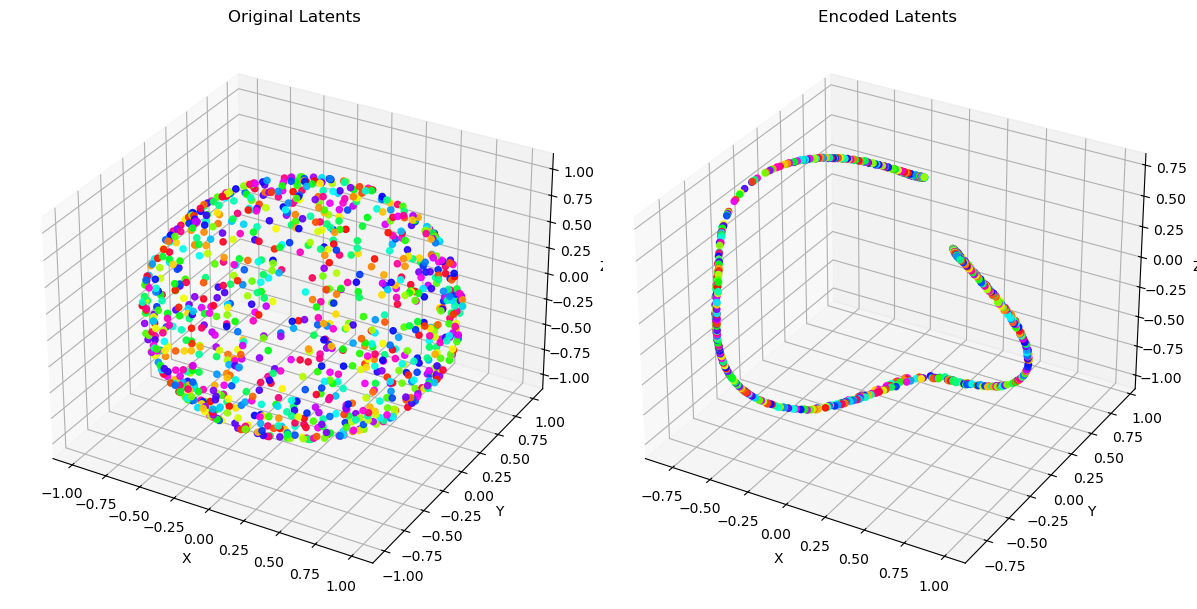

In [27]:
from experiment_utils.linear import perform_linear_experiment

h = perform_linear_experiment(
    6, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.536331176757812 Samples processed: 1 linear disentanglement: 0.36173930764198303 permutation disentanglement: -1.7662843674770556e-05
Loss: 8.415362358093262 Samples processed: 251 linear disentanglement: 0.5371754765510559 permutation disentanglement: 0.1893915981054306
Loss: 8.414107322692871 Samples processed: 501 linear disentanglement: 0.3037594258785248 permutation disentanglement: 0.12562231719493866
Loss: 8.414128303527832 Samples processed: 751 linear disentanglement: 0.30204007029533386 permutation disentanglement: 0.12068653106689453
Loss: 8.414085388183594 Samples processed: 1001 linear disentanglement: 0.3031691312789917 permutation disentanglement: 0.12147220224142075
Loss: 8.414093017578125 Samples processed: 1251 linear disentanglement: 0.3018759787082672 permutation disentanglement: 0.12735551595687866
Loss: 8.414129257202148 Samples processed: 1501 linear disentanglement: 0.3036104142665863 permutation d

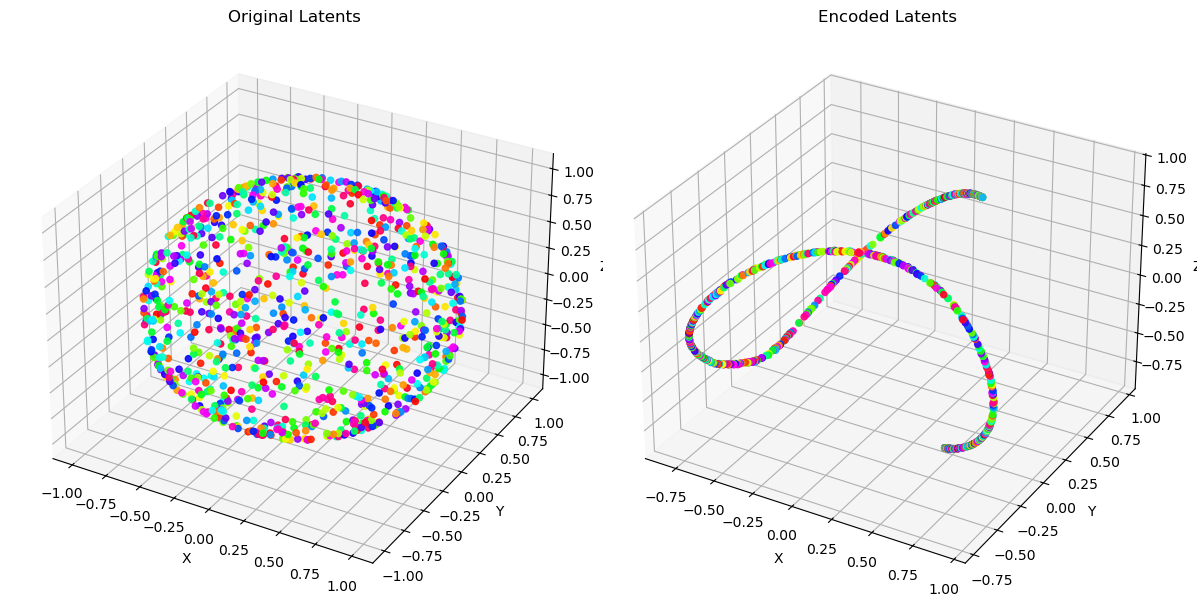

In [28]:
from experiment_utils.linear import perform_linear_experiment

h = perform_linear_experiment(
    7, iterations, batch_size, latent_dim, sample_pair_fixed, sample_uniform_fixed, tau, device
)

z = full_sphere.uniform(1000).to(device)
z_enc = h(z)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Spiral generating process

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.53640365600586 Samples processed: 1 linear disentanglement: 0.22726450860500336 permutation disentanglement: 4.233916479279287e-05
Loss: 8.435198783874512 Samples processed: 251 linear disentanglement: 0.3030821979045868 permutation disentanglement: 0.00950030516833067
Loss: 8.434280395507812 Samples processed: 501 linear disentanglement: 0.3119303286075592 permutation disentanglement: 0.021576782688498497
Loss: 8.434335708618164 Samples processed: 751 linear disentanglement: 0.31489893794059753 permutation disentanglement: 0.03785425424575806
Loss: 8.433734893798828 Samples processed: 1001 linear disentanglement: 0.3222637474536896 permutation disentanglement: 0.0359322614967823
Loss: 8.435041427612305 Samples processed: 1251 linear disentanglement: 0.3529386520385742 permutation disentanglement: 0.05153657868504524
Loss: 8.434917449951172 Samples processed: 1501 linear disentanglement: 0.36059561371803284 permutation di

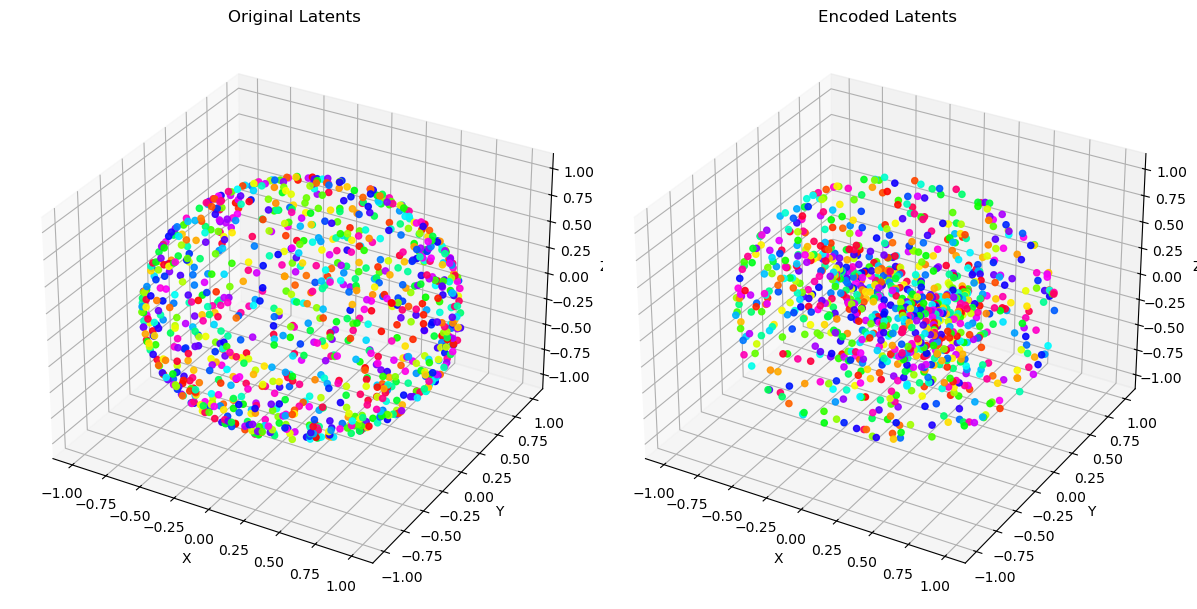

In [30]:
from data.generation import SpiralRotation

f_spiral = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

g_spiral = SpiralRotation(2)

simclr_spiral = SimCLR(
    f_spiral, g_spiral, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_spiral = simclr_spiral.train(batch_size, iterations * 2)
h_spiral = lambda z: f_spiral(g_spiral(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_spiral(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Patched generating process

Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.53639030456543 Samples processed: 1 linear disentanglement: 0.41878247261047363 permutation disentanglement: -0.00012894471001345664
Loss: 8.428019523620605 Samples processed: 251 linear disentanglement: 0.7049422264099121 permutation disentanglement: 0.1928223967552185
Loss: 8.423726081848145 Samples processed: 501 linear disentanglement: 0.8512255549430847 permutation disentanglement: 0.21931497752666473
Loss: 8.423405647277832 Samples processed: 751 linear disentanglement: 0.8824717998504639 permutation disentanglement: 0.2620992362499237
Loss: 8.422789573669434 Samples processed: 1001 linear disentanglement: 0.9004537463188171 permutation disentanglement: 0.28331872820854187
Loss: 8.422710418701172 Samples processed: 1251 linear disentanglement: 0.9122216105461121 permutation disentanglement: 0.2633821666240692
Loss: 8.42258071899414 Samples processed: 1501 linear disentanglement: 0.9171672463417053 permutation disent

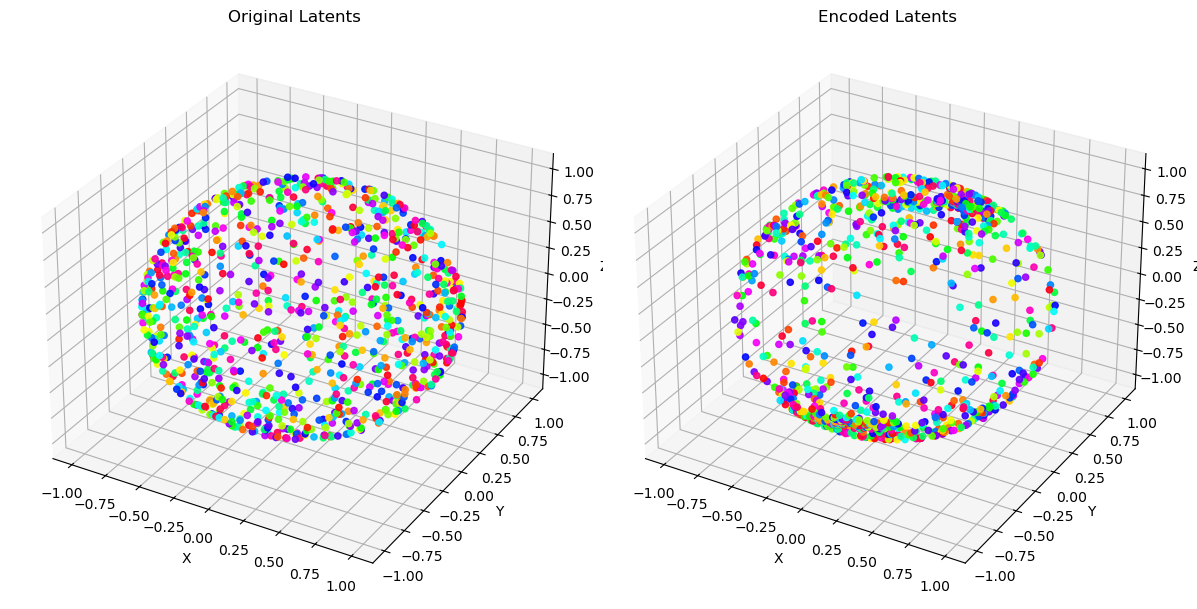

In [31]:
from data.generation import Patches

g_patches = Patches(5, device)
f_patches = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

simclr_patches = SimCLR(
    f_patches, g_patches, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_patches = simclr_patches.train(batch_size, iterations * 2)
h_patches = lambda z: f_patches(g_patches(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_patches(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Experiment with the invertible MLP as a data generating process

condition number threshold: 1.027612
layer 1/3,  condition number: 1.0262671213163295
layer 2/3,  condition number: 1.0263230608700205
layer 3/3,  condition number: 1.0215649680066952


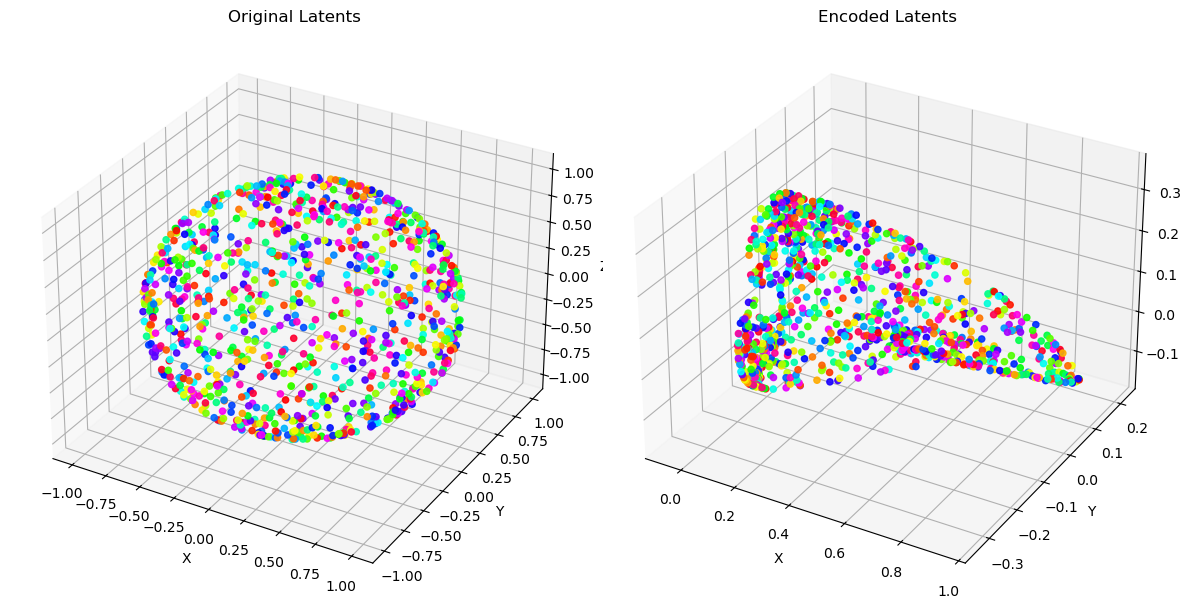

In [11]:
from invertible_network_utils import construct_invertible_mlp

g_mlp = construct_invertible_mlp(
        n=3,
        n_layers=3,
        act_fct='leaky_relu',
        cond_thresh_ratio=0.0,
        n_iter_cond_thresh=25000,
).to(device)

z = full_sphere.uniform(1000).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), g_mlp(z).cpu())

condition number threshold: 1.039983
layer 1/3,  condition number: 1.0182842121142552
layer 2/3,  condition number: 1.0386268837487342
layer 3/3,  condition number: 1.0358627764043027
Linear control score: 1.0
Permutation control score: 1.0
Loss: 8.536399841308594 Samples processed: 1 linear disentanglement: 0.5141821503639221 permutation disentanglement: 0.0011450847378000617
Loss: 8.420354843139648 Samples processed: 251 linear disentanglement: 0.6974180340766907 permutation disentanglement: 0.0681939348578453
Loss: 8.418198585510254 Samples processed: 501 linear disentanglement: 0.6380296349525452 permutation disentanglement: 0.05413442850112915
Loss: 8.417097091674805 Samples processed: 751 linear disentanglement: 0.5974226593971252 permutation disentanglement: 0.07606156915426254
Loss: 8.416400909423828 Samples processed: 1001 linear disentanglement: 0.5658752918243408 permutation disentanglement: 0.09893663972616196
Loss: 8.415926933288574 Samples processed: 1251 linear disentang

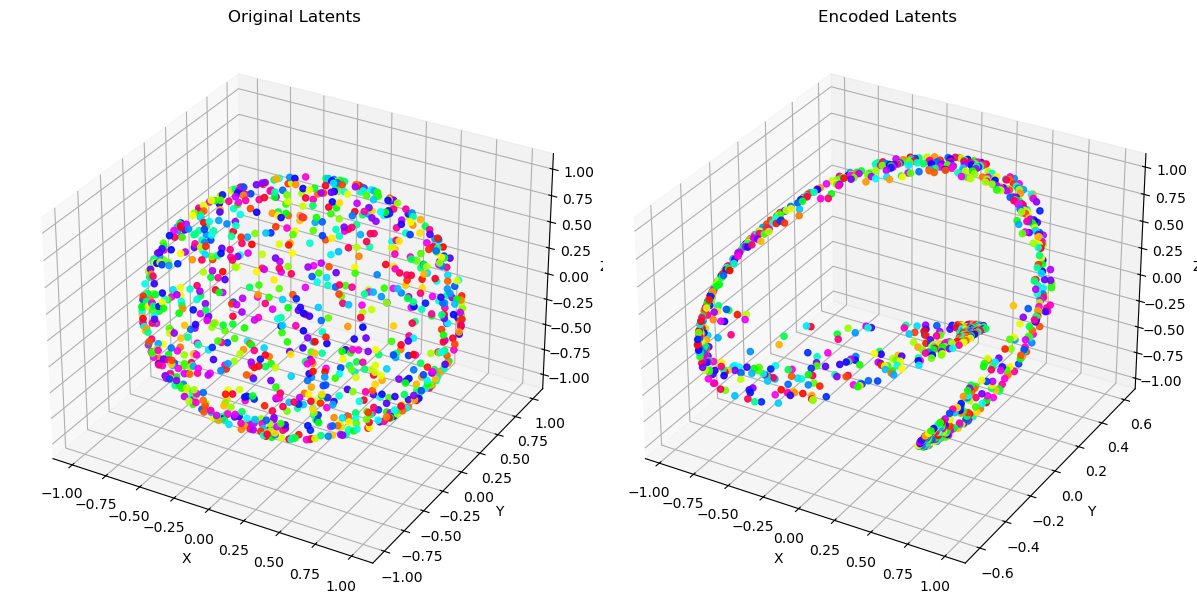

In [ ]:
f_mlp = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to(device)

simclr_mlp = SimCLR(
    f_mlp, g_mlp, sample_pair_fixed, sample_uniform_fixed, tau, device=device
)

f_mlp = simclr_mlp.train(batch_size, iterations)
h_mlp = lambda latent: f_mlp(g_mlp(latent))

z = full_sphere.uniform(1000).to(device)
z_enc = h_mlp(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

## Next

- Run it with a correct model (Cross-Entropy with a correct normalizer)